# Iranian telecom company Churn

## Data Loading

In [71]:
import numpy as np
import math
import regex as re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump, load
import shap

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from ucimlrepo import fetch_ucirepo 
  
iranian_churn = fetch_ucirepo(id=563) 
  
X = iranian_churn.data.features 
y = iranian_churn.data.targets 

print(iranian_churn.metadata) 
print(iranian_churn.variables) 

{'uci_id': 563, 'name': 'Iranian Churn', 'repository_url': 'https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/563/data.csv', 'abstract': "This dataset is randomly collected from an Iranian telecom company's database over a period of 12 months.", 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 3150, 'num_features': 13, 'feature_types': ['Integer'], 'demographics': ['Age'], 'target_col': ['Churn'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Sat Mar 09 2024', 'dataset_doi': '10.24432/C5JW3Z', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is randomly collected from an Iranian telecom companyâ€™s database over a period of 12 months. A total of 3150 rows of data, each representing a customer, bear information for 13 columns. The attribu

In [4]:
df = pd.concat([X,y],axis=1)
df.head(10)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
5,11,0,38,1,3775,82,32,28,3,1,1,30,282.280,0
6,4,0,38,0,2360,39,285,18,3,1,1,30,1235.960,0
7,13,0,37,2,9115,121,144,43,3,1,1,30,945.440,0
8,7,0,38,0,13773,169,0,44,3,1,1,30,557.680,0
9,7,0,38,1,4515,83,2,25,3,1,1,30,191.920,0


## Metadata



- **Call Failures**: number of call failures

- **Complains**: binary (0: No complaint, 1: complaint)

- **Subscription Length**: total months of subscription

- **Charge Amount**: Ordinal attribute (0: lowest amount, 9: highest amount)

- **Seconds of Use**: total seconds of calls

- **Frequency of use**: total number of calls

- **Frequency of SMS**: total number of text messages

- **Distinct Called Numbers**: total number of distinct phone calls 

- **Age Group**: ordinal attribute (1: younger age, 5: older age)

- **Tariff Plan**: binary (1: Pay as you go, 2: contractual)

- **Status**: binary (1: active, 2: non-active)

- **Churn**: binary (1: churn, 0: non-churn) - Class label

- **Customer Value**: The calculated value of the customer

## Data Cleaning

In [8]:
# Dropping Customer Age column since we already have a Column with Age encoded into Age groups of 1 to 5
df.drop(columns=['Age'], inplace=True)

In [9]:
# Remove whitespace when one or more whitespace characters & trailing and leading spaces
df.columns = [re.sub('\s+', ' ', col.strip()) for col in df.columns]

## Descriptive Statistics

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call Failure             3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription Length      3150 non-null   int64  
 3   Charge Amount            3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Customer Value           3150 non-null   float64
 12  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 320.1 KB


In [12]:
df.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Customer Value,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,2165.280000,1.000000


# Univariate Analysis

In [14]:
columns = df.columns

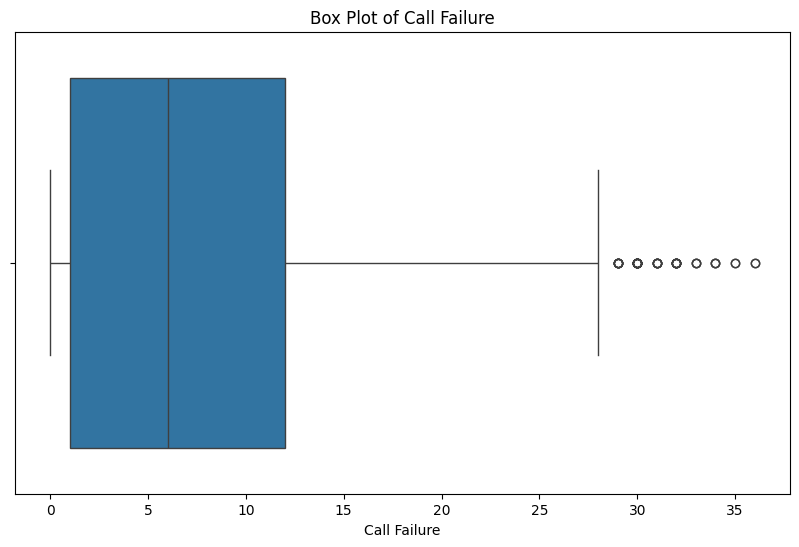

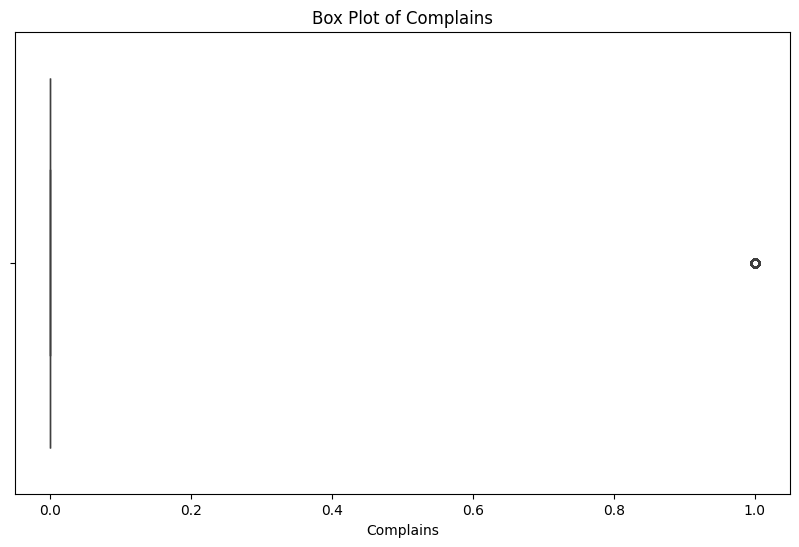

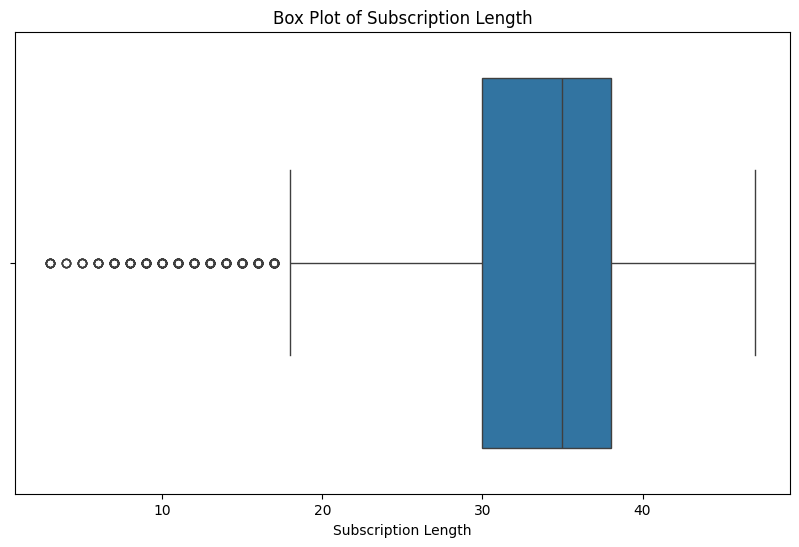

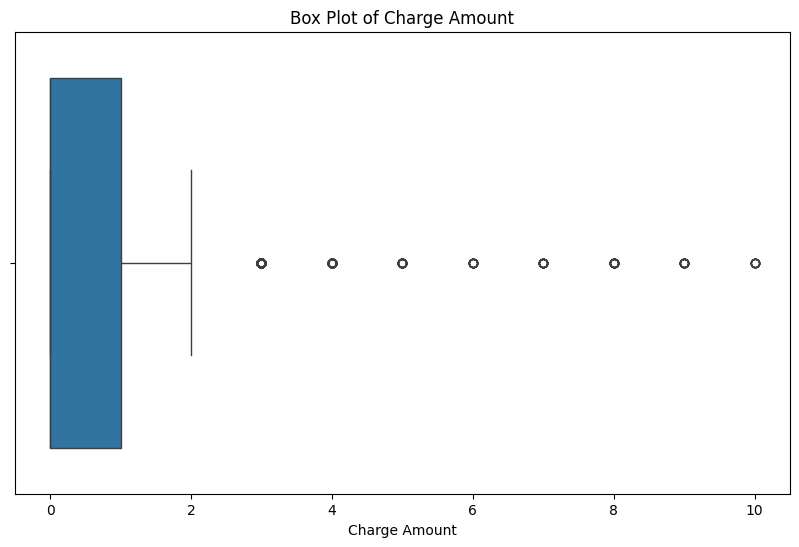

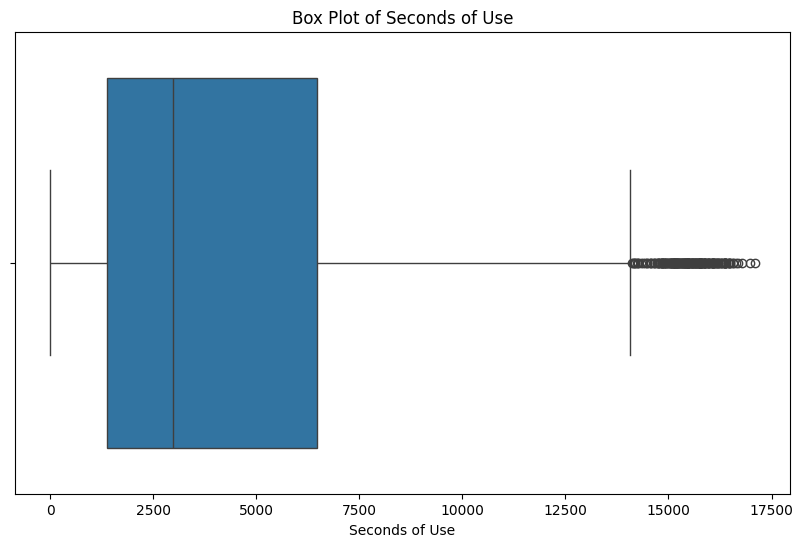

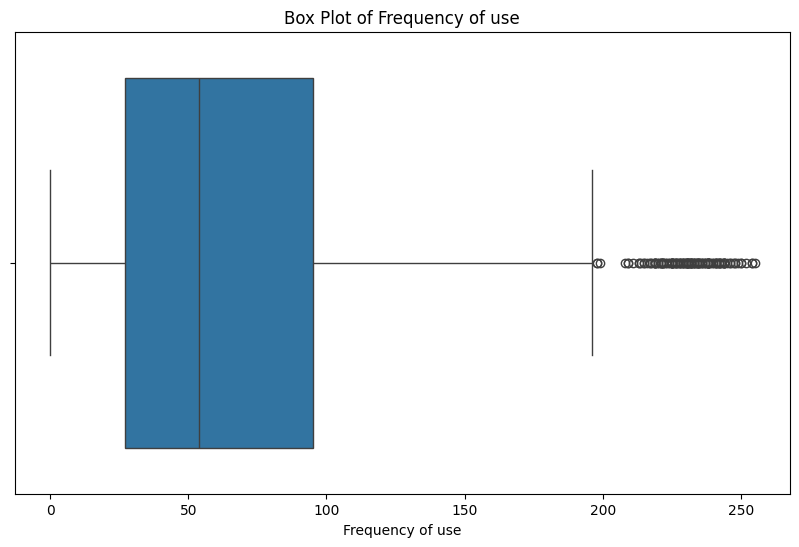

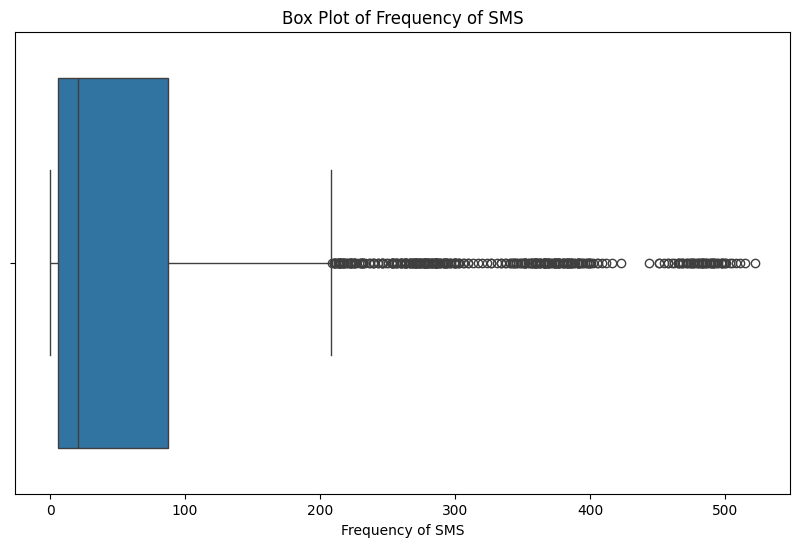

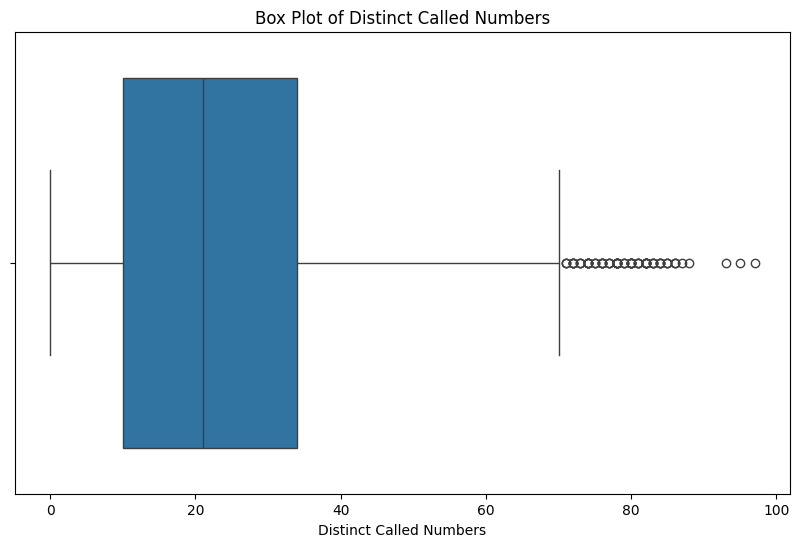

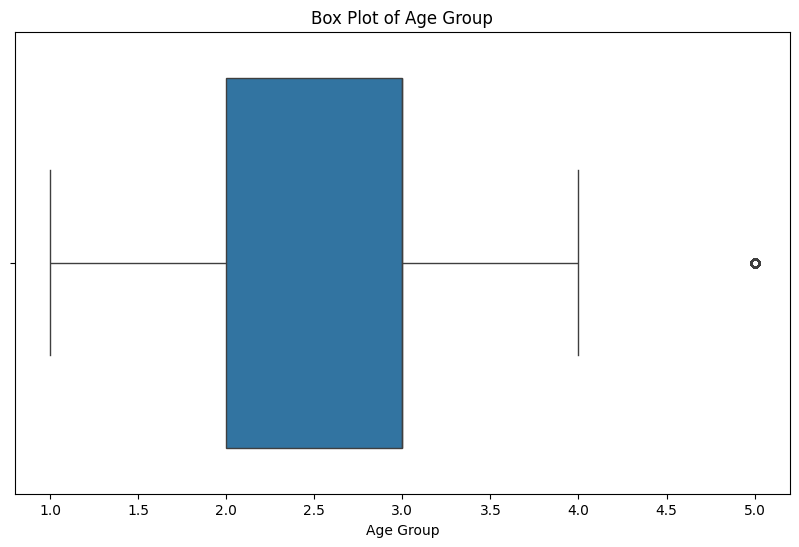

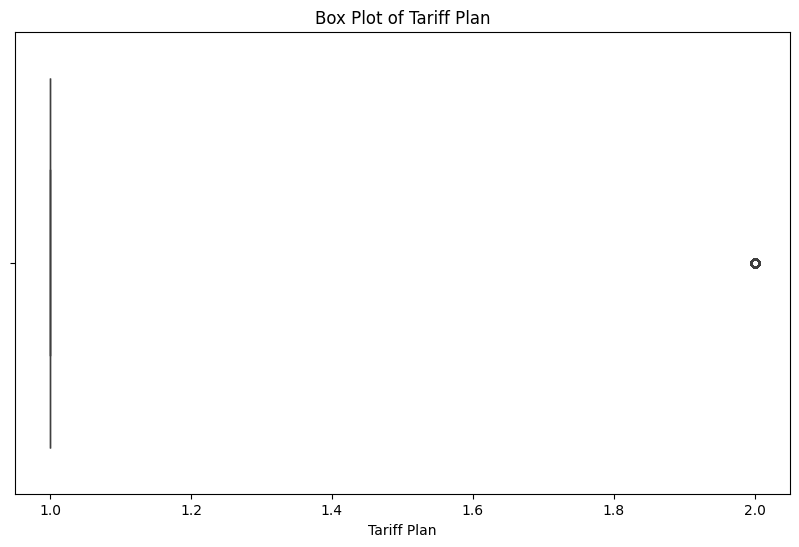

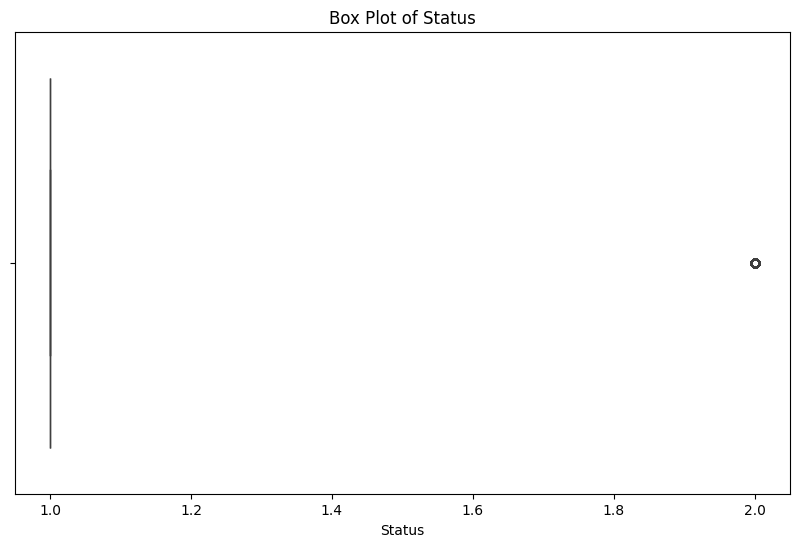

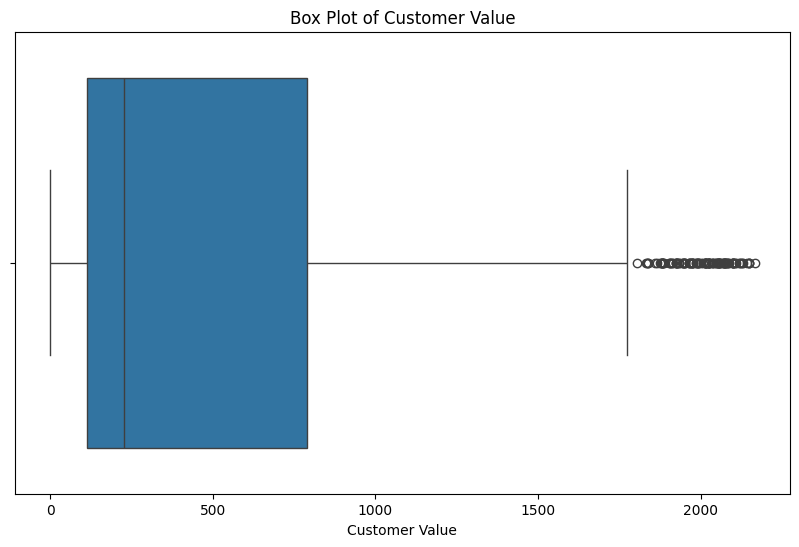

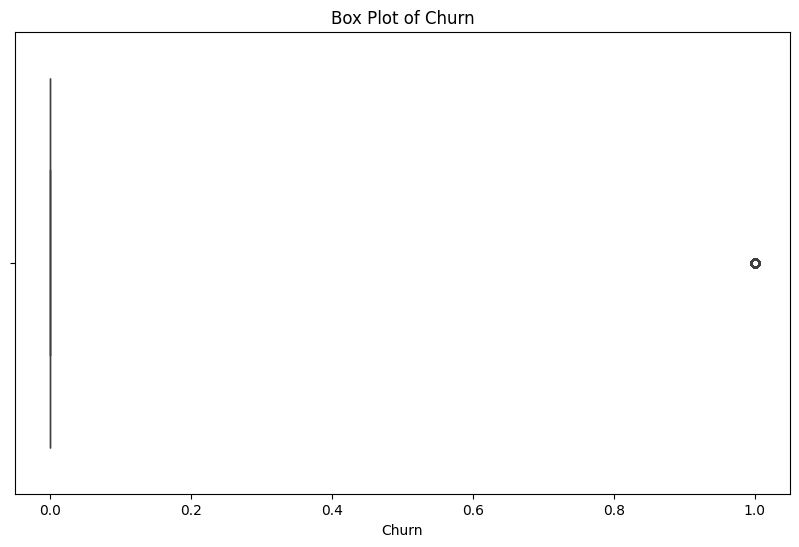

In [15]:
# Plotting all features as box plot to visualise Outliers
for column in columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

Outliers are present in the numerical features of the dataset.
Common Steps to handle it:
1. Ignore
2. Delete
3. Impute

However, since the outliers do not seem to be errors during data collection, we have decided to **retain them**. Instead of handling the outliers, we are using a **Machine Learning model** that is **robust to their presence**.

**Standard Scaler** is recommended over Min Max Scaler for normalization of features as it is more robust to outliers.

## Models Robust to Outliers


1. **Decision Trees and Random Forests**

2. **Gradient Boosting Machines (e.g., XGBoost, LightGBM)**

3. **Support Vector Machines with non-linear kernels**

---

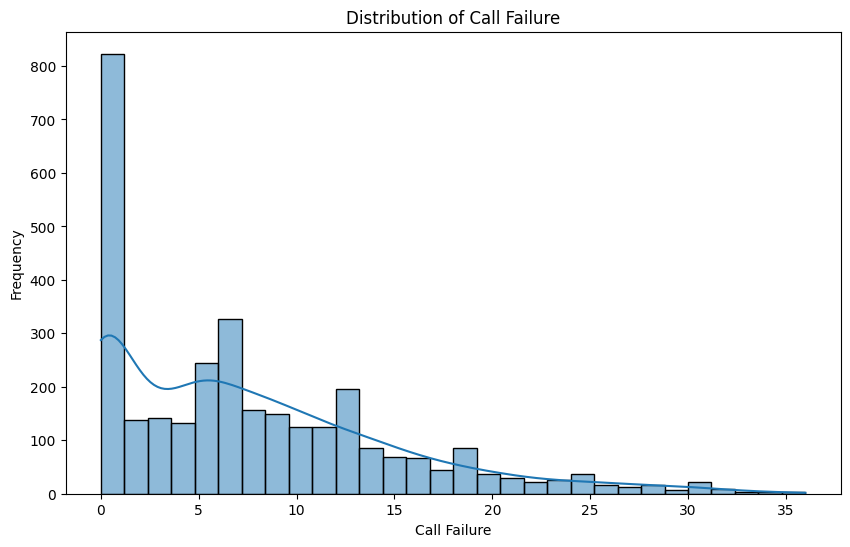

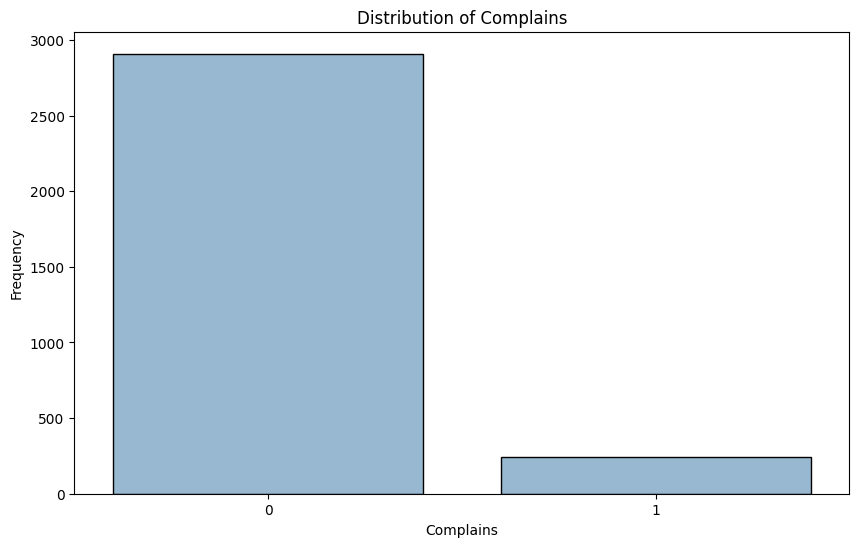

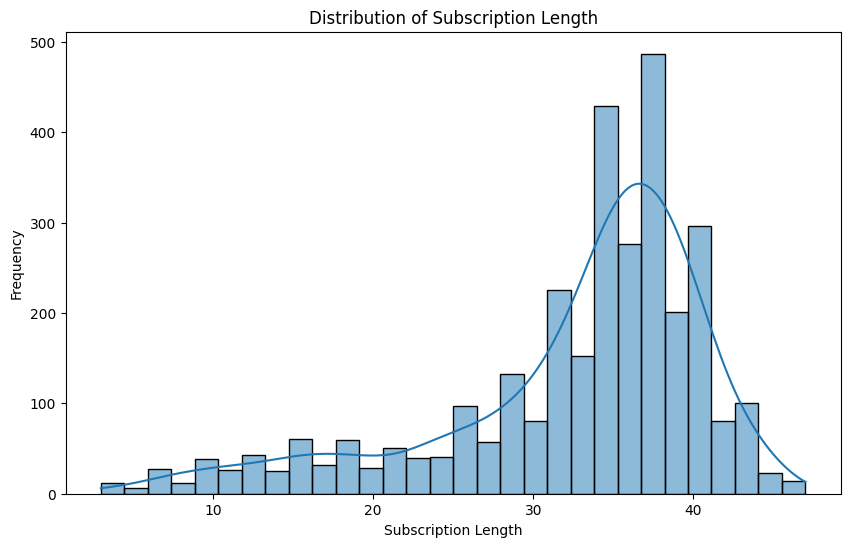

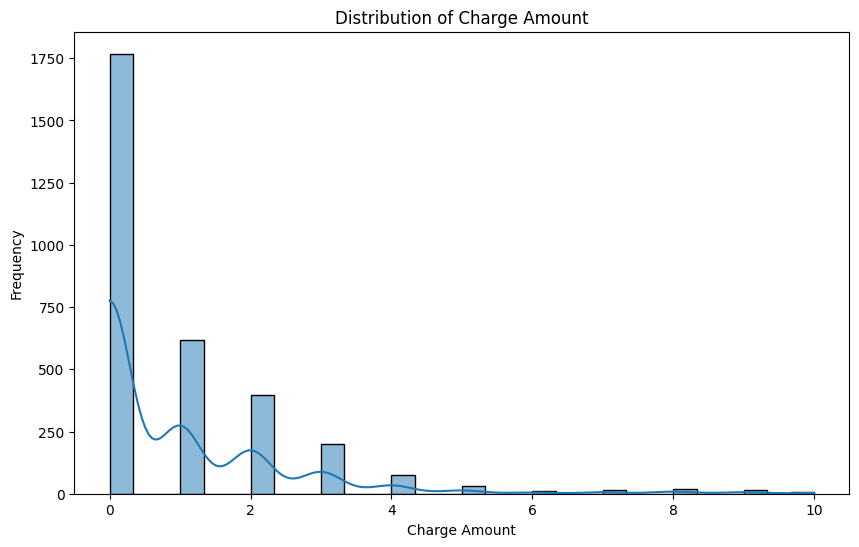

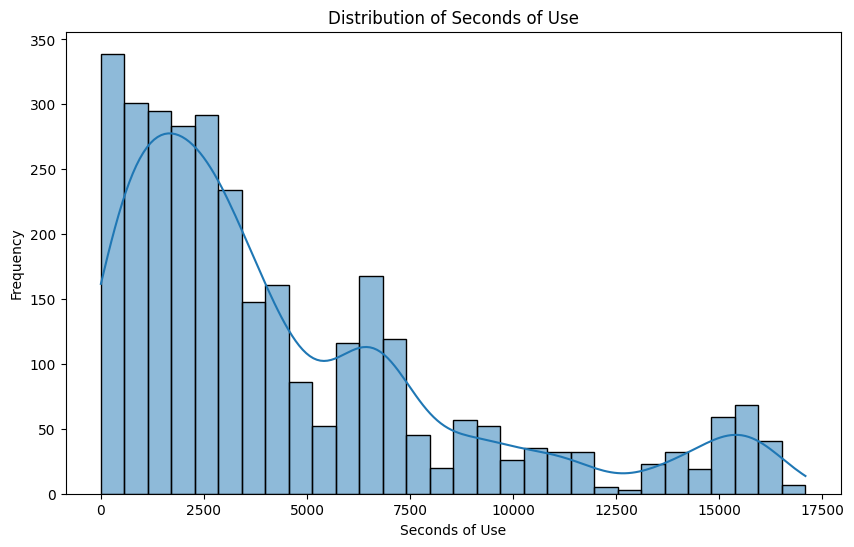

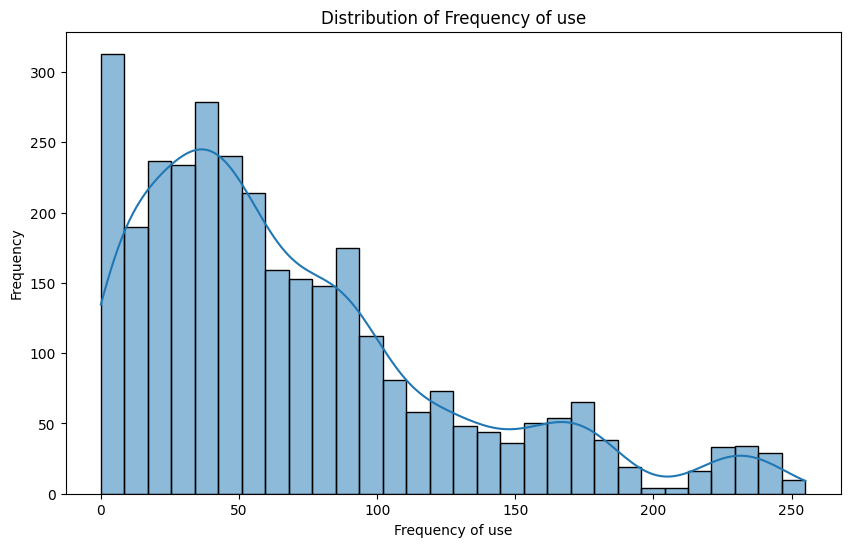

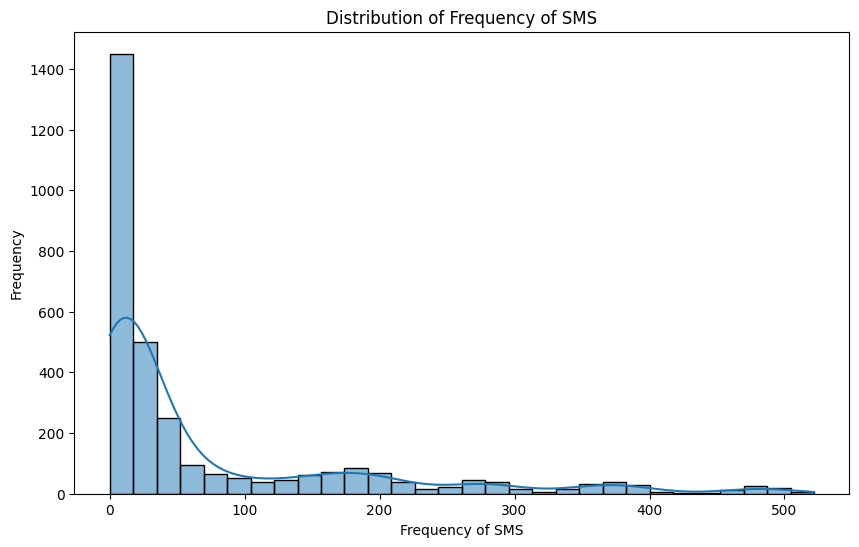

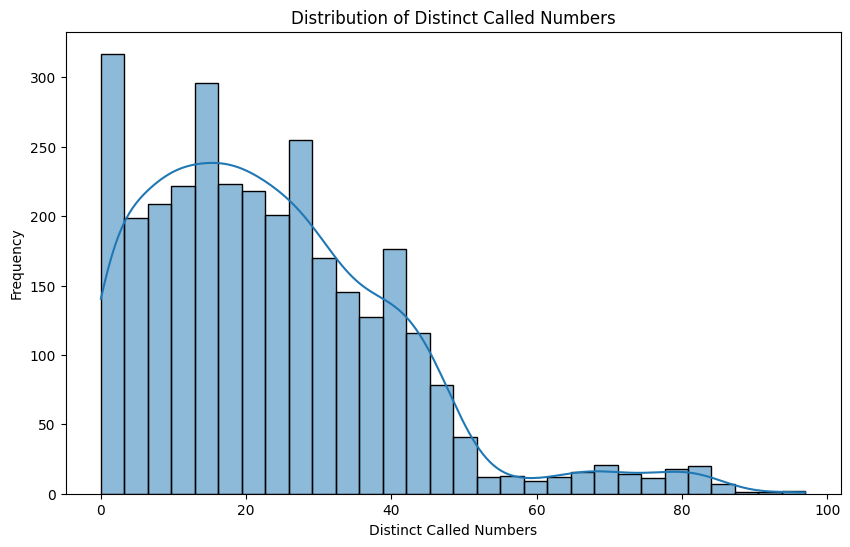

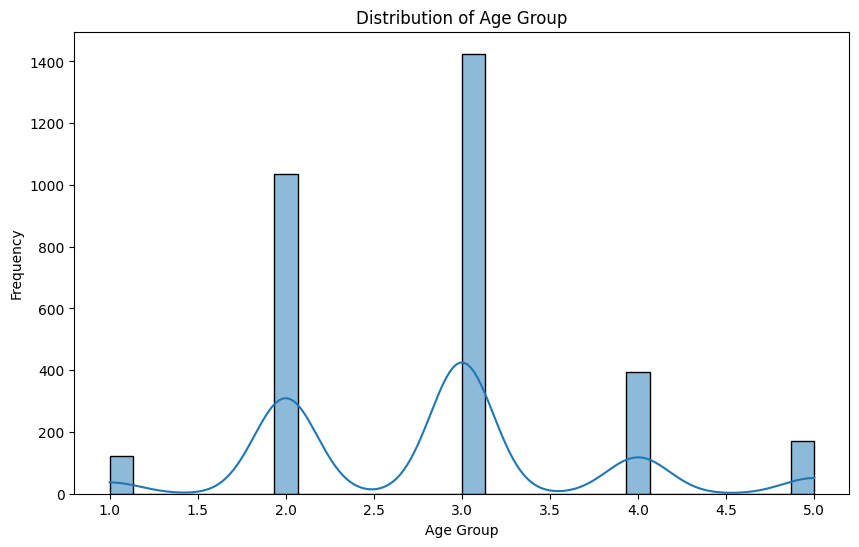

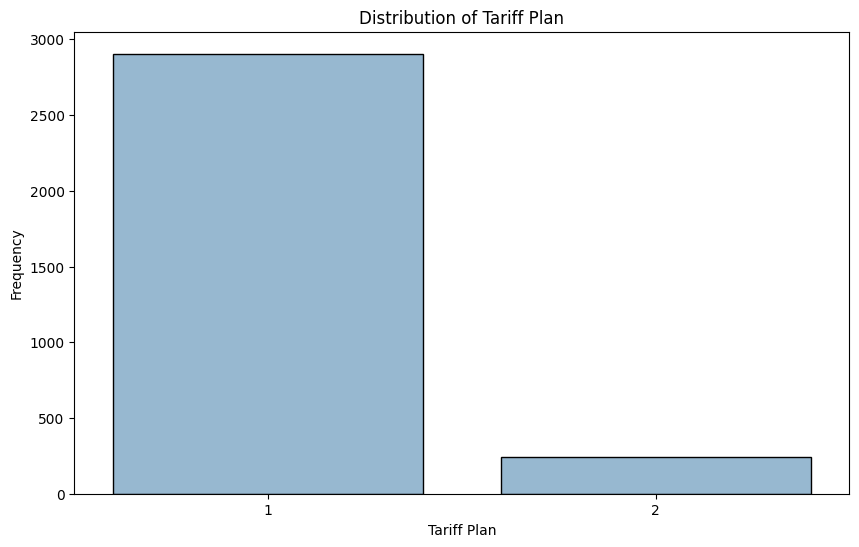

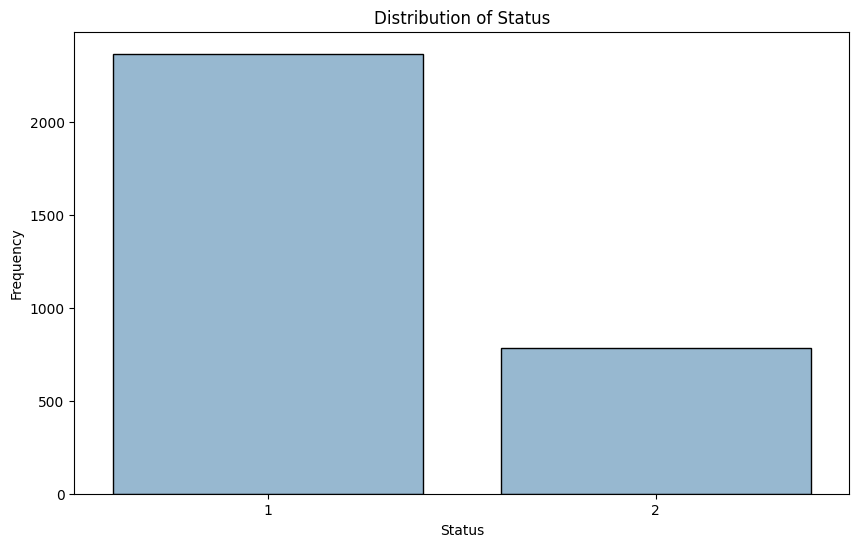

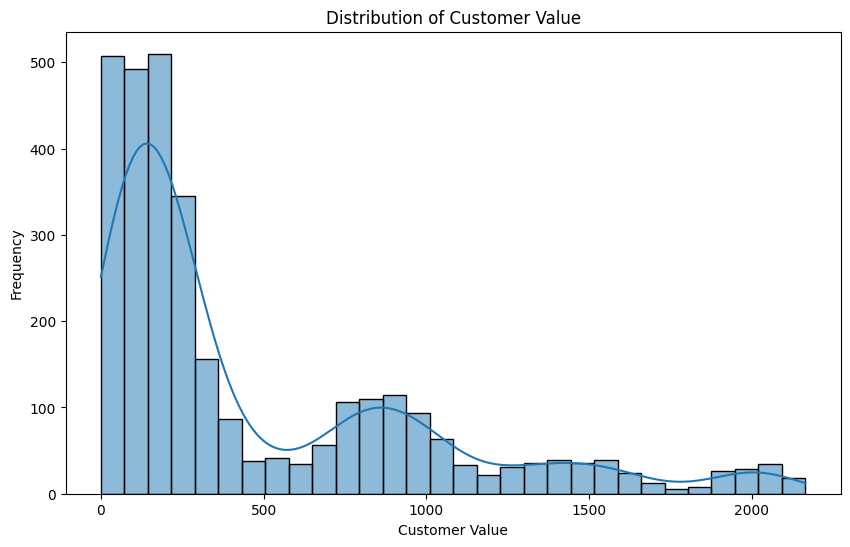

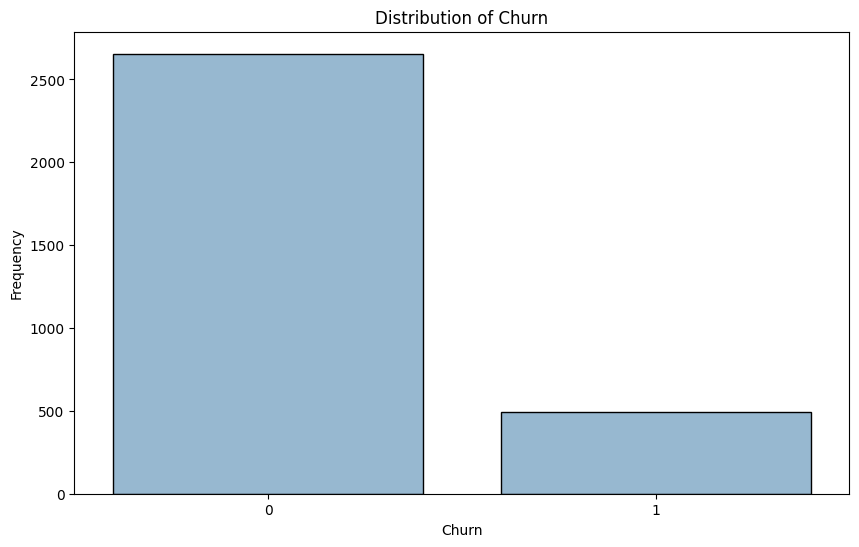

In [19]:
# Plotting all features to visualise distribution
for col in columns:
    plt.figure(figsize=(10, 6))
    if df[col].nunique()==2:
        sns.countplot(x=df[col], color='#8EBAD9', edgecolor='black')
    else:
        sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

The numerical data is not of Normal/Gaussian distribution.
Hence **Standard Scaler** is recommended over Min Max Scaler for normalization of features.

---

In [22]:
count = len(df)

### 1. There are lots of Call Failures around 1-15 numbers

In [24]:
cf_0=df['Call Failure'].value_counts().loc[0]
print(f'The number of Call failures at 0: {cf_0}')

cf_1_15=df['Call Failure'].value_counts().sort_index().loc[1:15].sum()
print(f'The number of Call failures between 1 to 15: {cf_1_15}')

cf_1_15=df['Call Failure'].value_counts().sort_index().loc[15:].sum()
print(f'The number of Call failures more than 15: {cf_1_15}')

The number of Call failures at 0: 702
The number of Call failures between 1 to 15: 2007
The number of Call failures more than 15: 510


### 2. The distribution of calls with complains is disproportionate to that of ones without complains. It must be handled before or during training model

In [26]:
c_0=df['Complains'].value_counts().loc[0]
print(f'The number of No Complains reported: {c_0}')

c_1=df['Complains'].value_counts().loc[1]
print(f'The number of Complaints reported: {c_1}')

The number of No Complains reported: 2909
The number of Complaints reported: 241


### 3. Around 75 % of the customers are of moderate commitment with subscriptions for 25 to 40 months. Long-term subscribers make up around 16 % of the Subscription

In [28]:
sl_25_40=df['Subscription Length'].value_counts().sort_index().loc[25:40].sum()
print(f'The number of customers with subscription of less than 25 months: {sl_25_40}, ie. {sl_25_40*100/count}%')

sl_0_25=df['Subscription Length'].value_counts().sort_index().loc[:25].sum()
print(f'The number of customers with subscription between 25 to 40 months: {sl_0_25}, ie. {sl_0_25*100/count}%')

sl_40=df['Subscription Length'].value_counts().sort_index().loc[40:].sum()
print(f'The number of customers with subscription of more than 40 months: {sl_40}, ie. {sl_40*100/count}%')

The number of customers with subscription of less than 25 months: 2322, ie. 73.71428571428571%
The number of customers with subscription between 25 to 40 months: 553, ie. 17.555555555555557%
The number of customers with subscription of more than 40 months: 513, ie. 16.285714285714285%


### 4. 94 % of the Customers are of Charge Amount 0 to 3

In [30]:
ca_0 = df['Charge Amount'].value_counts().loc[0]
print(f'Number of Customers are of Charge Amount 0 : {ca_0}, ie. {ca_0*100/count}')

ca_1_3 = df['Charge Amount'].value_counts().sort_index().loc[1:3].sum()
print(f'Number of Customers are betwween Charge Amount 1 to 3: {ca_1_3}, ie.{ca_1_3*100/count}')

Number of Customers are of Charge Amount 0 : 1768, ie. 56.12698412698413
Number of Customers are betwween Charge Amount 1 to 3: 1211, ie.38.44444444444444


### 5. The age distirbution is normally distributed with most of the customers being middle ages(around 30 years of age).

In [32]:
df['Age Group'].value_counts().sort_index()

Age Group
1     123
2    1037
3    1425
4     395
5     170
Name: count, dtype: int64

### 6.  92 % of Customers are subsribed to Tariff plan 1 while only around 8 % prefer the Tariff plan 2

In [34]:
tf_1 = df['Tariff Plan'].value_counts().loc[1]
print(f'Number of Customers subscribed to Tariff plan 1: {tf_1}, ie {tf_1*100/count}')

tf_2 = df['Tariff Plan'].value_counts().loc[2]
print(f'Number of Customers subscribed to Tariff plan 1: {tf_2}, ie {tf_2*100/count}')

Number of Customers subscribed to Tariff plan 1: 2905, ie 92.22222222222223
Number of Customers subscribed to Tariff plan 1: 245, ie 7.777777777777778


### 7. 75 % of Customers are active while the remaining 25 % are non-active

In [36]:
s_1 = df['Status'].value_counts().loc[1]
print(f'Number of Customers Active: {s_1}, ie {s_1*100/count}')

s_2 = df['Status'].value_counts().loc[2]
print(f'Number of Customers Non-active: {s_2}, ie {s_2*100/count}')

Number of Customers Active: 2368, ie 75.17460317460318
Number of Customers Non-active: 782, ie 24.825396825396826


### 8. 67 % of the Customers have a Customer Value below 500 and 20 % make up the Customer value brack between 500-1200

In [38]:
cv_1=df['Customer Value'].value_counts().sort_index().loc[:500].sum()
print(f'The number of customers with Customer Value of less than 500: {cv_1}, ie. {cv_1*100/count}%')

cv_2=df['Customer Value'].value_counts().sort_index().loc[500:1200].sum()
print(f'The number of customers with Customer Value between 25 to 40 months: {cv_2}, ie. {cv_2*100/count}%')

cv_3=df['Customer Value'].value_counts().sort_index().loc[1200:].sum()
print(f'The number of customers with Customer Value of more than 40 months: {cv_3}, ie. {cv_3*100/count}%')

The number of customers with Customer Value of less than 500: 2133, ie. 67.71428571428571%
The number of customers with Customer Value between 25 to 40 months: 671, ie. 21.3015873015873%
The number of customers with Customer Value of more than 40 months: 346, ie. 10.984126984126984%


### 9. 15 % of Customers churned. Being the target variable, this imbalance in data has to addressed before or during model training

In [40]:
y_0 = df['Churn'].value_counts().loc[0]
print(f'Number of Customers that did not Churn: {y_0}, ie {y_0*100/count}')

y_1 = df['Churn'].value_counts().loc[1]
print(f'Number of Customers Churned: {y_1}, ie {y_1*100/count}')

Number of Customers that did not Churn: 2655, ie 84.28571428571429
Number of Customers Churned: 495, ie 15.714285714285714


# Bivaraite Analysis

In [42]:
# Seperating Categorical and Numerical features
categorical_var = ['Complains', 'Charge Amount', 'Age Group', 'Tariff Plan', 'Status', 'Churn']
numerical_var = [col for col in df.columns if col not in categorical_var]

In [43]:
# Function to perform bivariate plotting of features based on feature type
def bi_var_analysis(category,target_variables):

    no_target = len(target_variables)
    if no_target%3==0:
        no_cols = 3
    else:
        no_cols = 2
    no_rows = math.ceil(no_target/no_cols)
    fig, axes = plt.subplots(no_rows, no_cols, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(target_variables):
        if col in categorical_var:
            countplot = sns.countplot(x=df[category], ax=axes[i], hue=df[col])
            axes[i].set_title(f'{col} based on {category}')

            total = len(df[category])
            for p in countplot.patches:
                percentage = '{:.1f}%'.format(100 * p.get_height() / total)
                x = p.get_x() + p.get_width() / 2
                y = p.get_height()
                if y > 0:
                    axes[i].annotate(percentage, (x, y), ha='center', va='bottom')

        else:
            barplot = sns.barplot(x=df[category], y=df[col], ax=axes[i])
            axes[i].set_title(f'{category} vs Average {col}')
            axes[i].set_xlabel(category)
            axes[i].set_ylabel(col)

            for p in barplot.patches:
                        height = p.get_height()
                        axes[i].annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2, height), 
                                         ha='center', va='bottom')

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

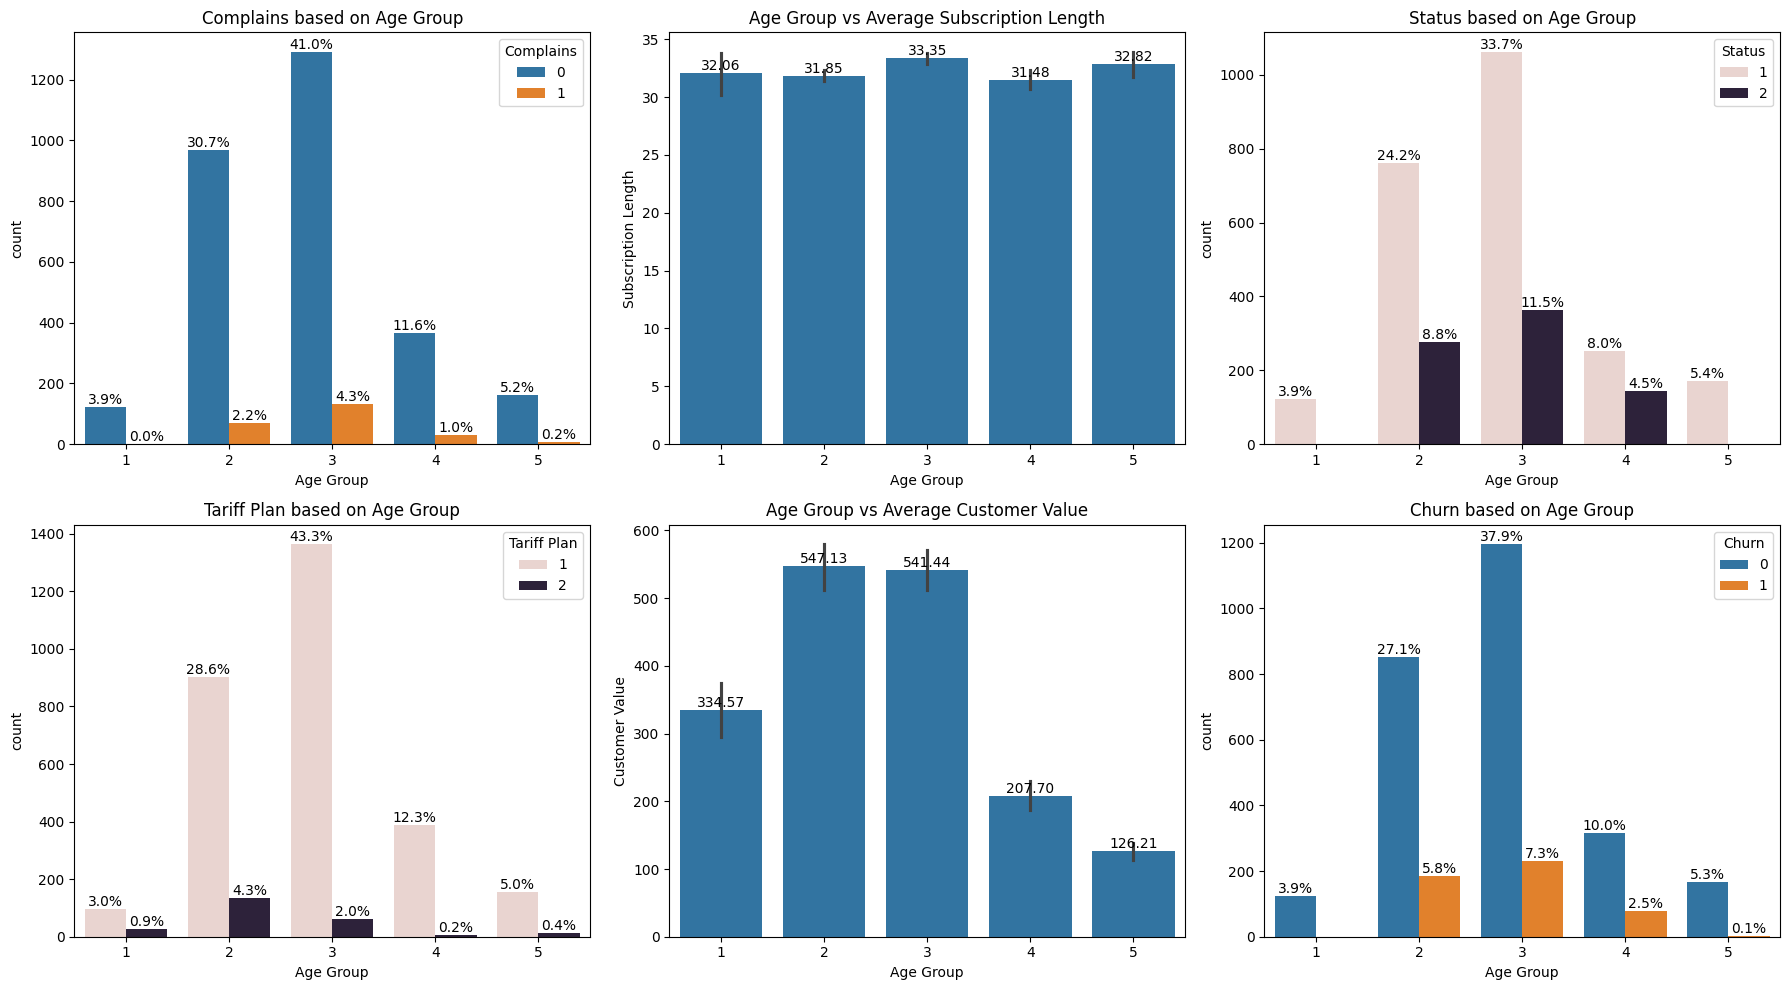

In [44]:
target_variables = ['Complains','Subscription Length','Status','Tariff Plan','Customer Value', 'Churn']
category = 'Age Group'

bi_var_analysis(category,target_variables)

#### 1. Age Group 3 has the most complaints per total share of each Group around 1 % followed by Age Group 4 around 0.8 %.
#### 2. The Average subscription length for all Age groups is similar.
#### 3. There are Non-active customers for Age groups 2, 3, and 4, with 4 having the highest total share of each Group around 36 % and 3 having around 25 %.
#### 4. Tariff Plan 2 has a low preference among all Age groups. Age Group 1 has 23 % of users and Age Group 2 has around 13 % of users with Tariff Plan 2.
#### 5. Age Groups 2 and 3 have the highest Average Customer Value of around 550, and Agr Group 5 has the lowest Average Customer Value.
#### 6. Age Groups 2, 3, and 4 have the highest Churn Rates at 17%, 16, and 20 % respectively while Age Group 5 has very little of 2 % and Age Group 1 has 0 Churn

---

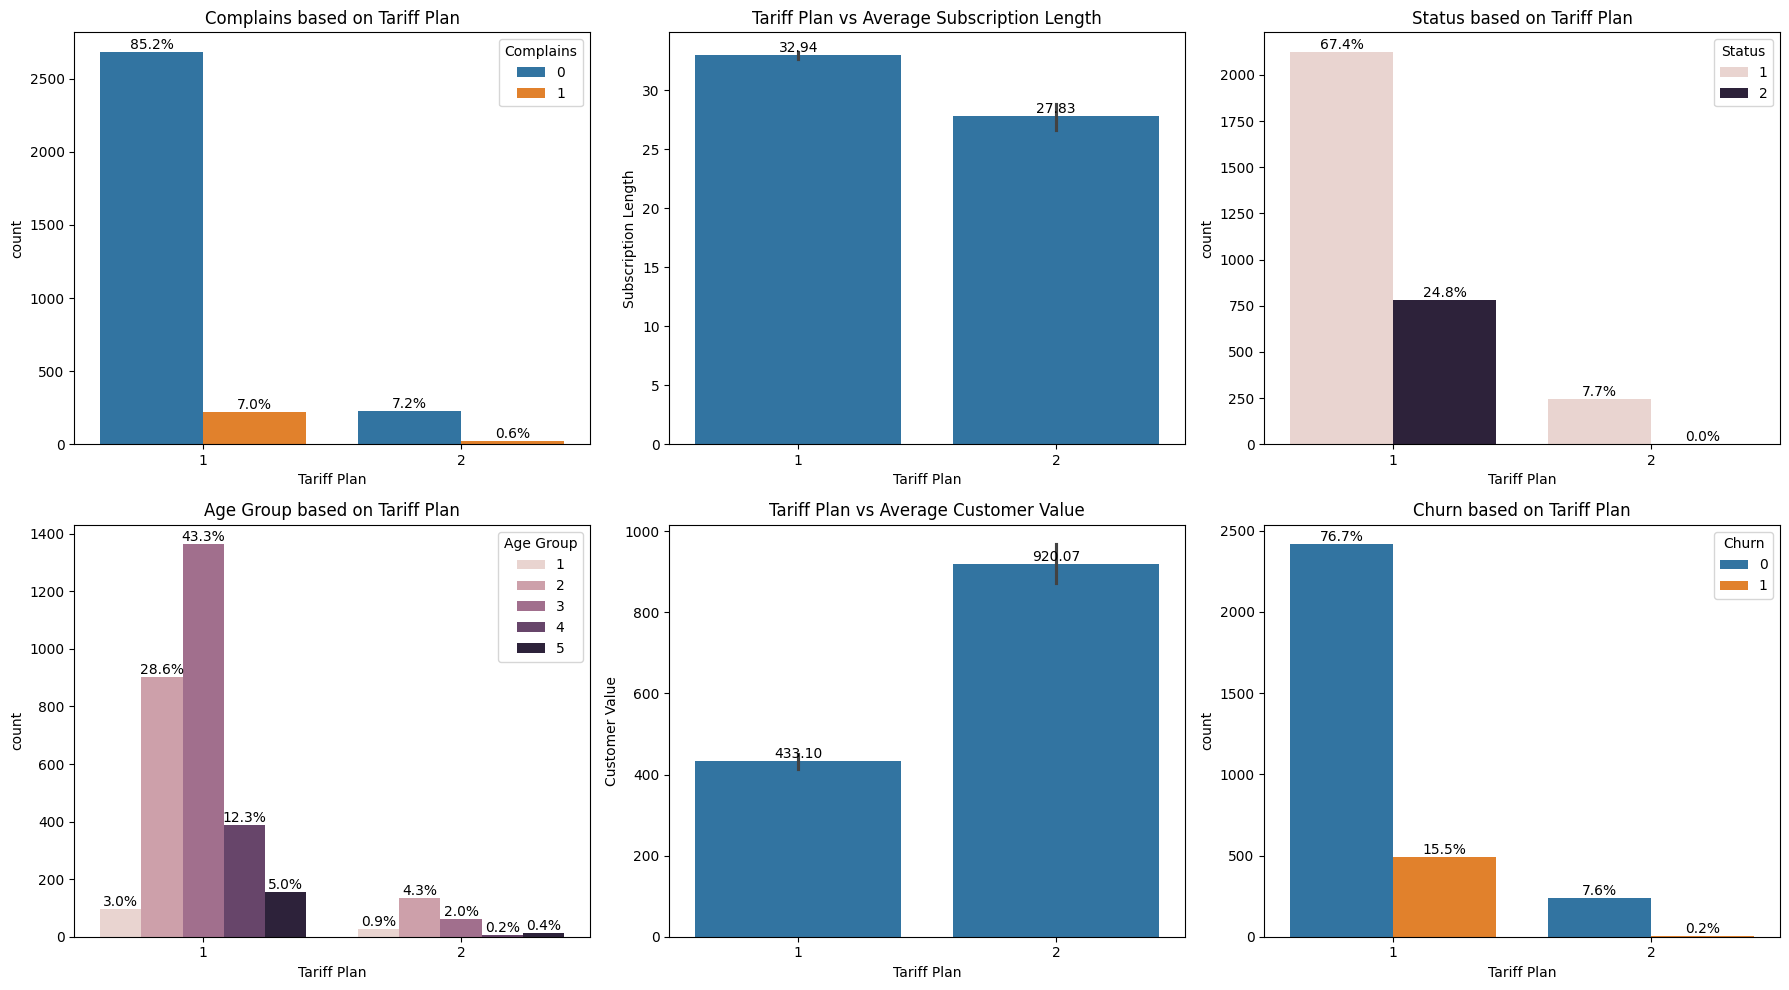

In [47]:
target_variables = ['Complains','Subscription Length','Status','Age Group','Customer Value', 'Churn']
category = 'Tariff Plan'

bi_var_analysis(category,target_variables)

#### 1. Tariff Plan 1 has 7.5% of users raising complaints and Tariff Plan 2 has 7.7% of users raising complaints, both at similar rates.
#### 2. Tariff Plan 1 users have a higher average subscription length than Tariff Plan 2 users.
#### 3. 25% of Tariff Plan 1 users are Non-active and there seem to be no Non-active users in Tariff Plan 2.
#### 4. Tariff Plan 1 mostly comprises Age Group 3 users followed by Age Group 2, and Tariff Plan 2 has Age Group 2 followed by Age Group 3 as the majority.
#### 5. The Average Customer Value of Tariff Plan 2 users is more than twice that of Tariff Plan 1 users.
#### 6. Churn Rate is much higher at 20%, almost 8 times, for Tariff Plan 1 users compared to Tariff Plan 2 users.

---

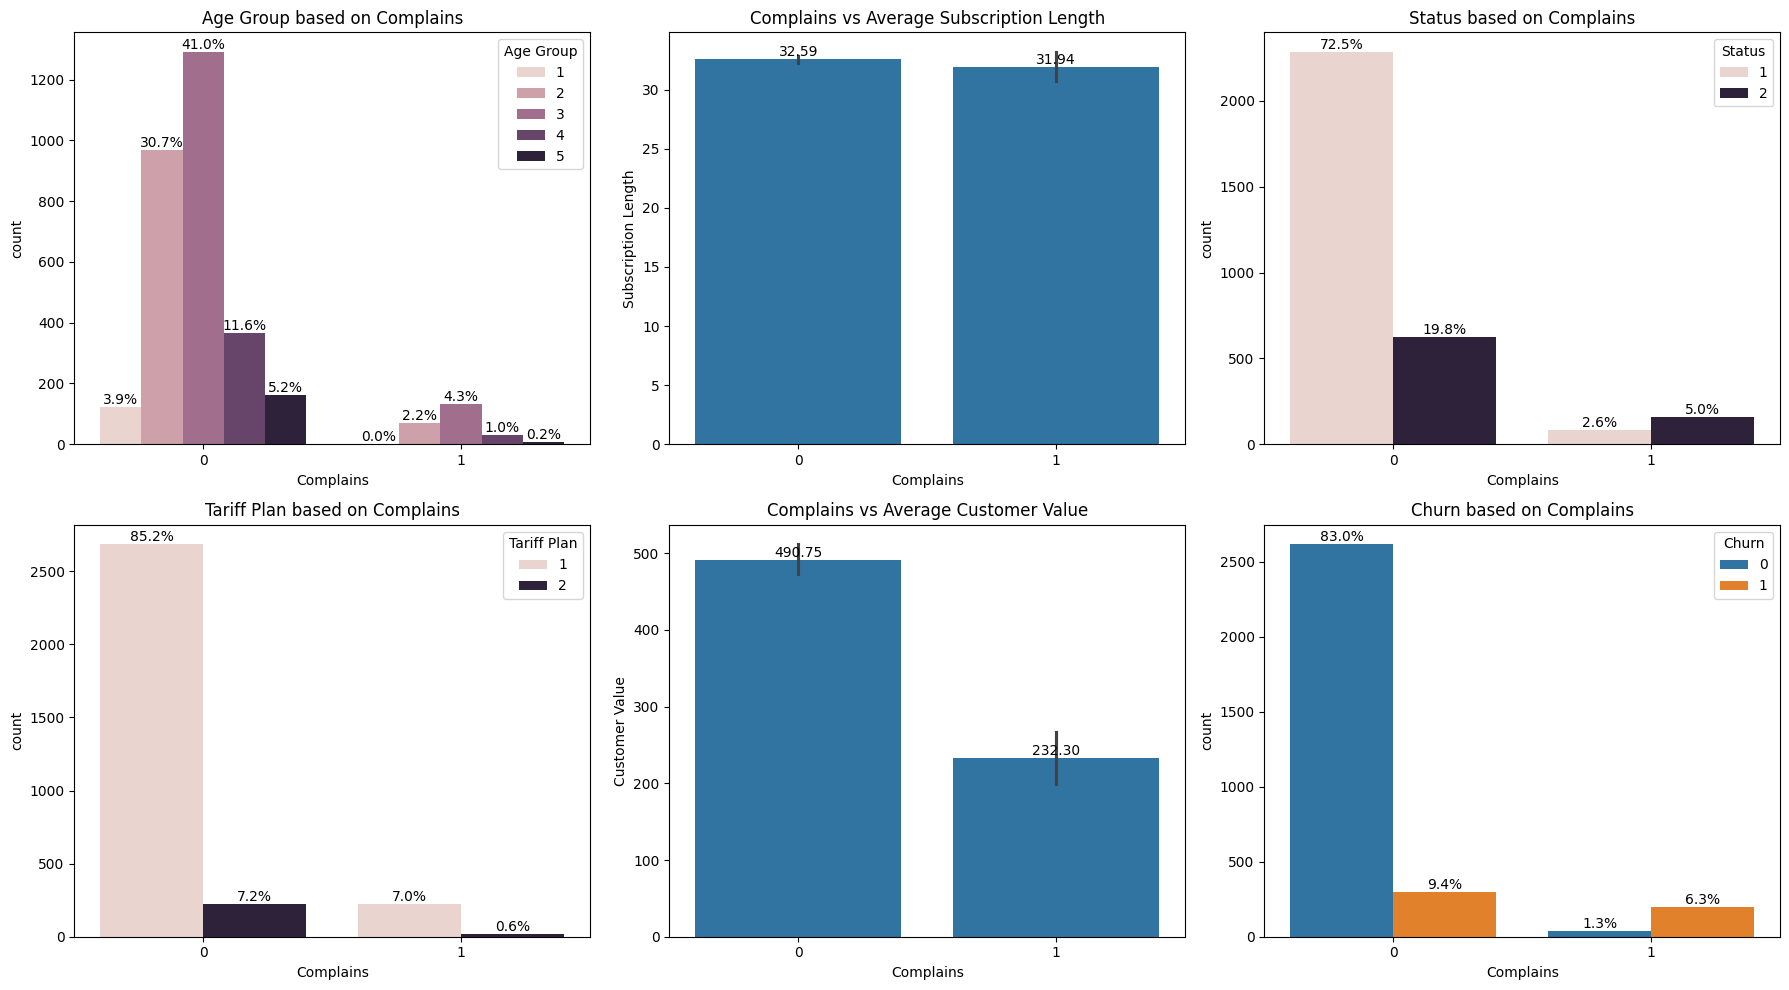

In [50]:
target_variables = ['Age Group','Subscription Length','Status','Tariff Plan','Customer Value', 'Churn']
category = 'Complains'

bi_var_analysis(category,target_variables)

#### 1. Complaints are mostly from Age Group 3 in numbers, which is linked to their higher total count.
#### 2. Users with Complaints have a similar Average Subscription length to Users without Complaints.
#### 3. In-active users tend to have more complaints than Active Users at a rate of 1 complaint for every 5 In-active users.
#### 4. Tariff Plan 1 has 7.5% of users raising complaints and Tariff Plan 2 has 7.7% of users raising complaints, both at similar rates.
#### 5. The Average Customer Value of users with no complaints is more than twice that of users with Complaints.
#### 6. Customers with Complaints churn by 83%, more than 8 times, as that of Customers without Complaints who only churn by 10%.

---

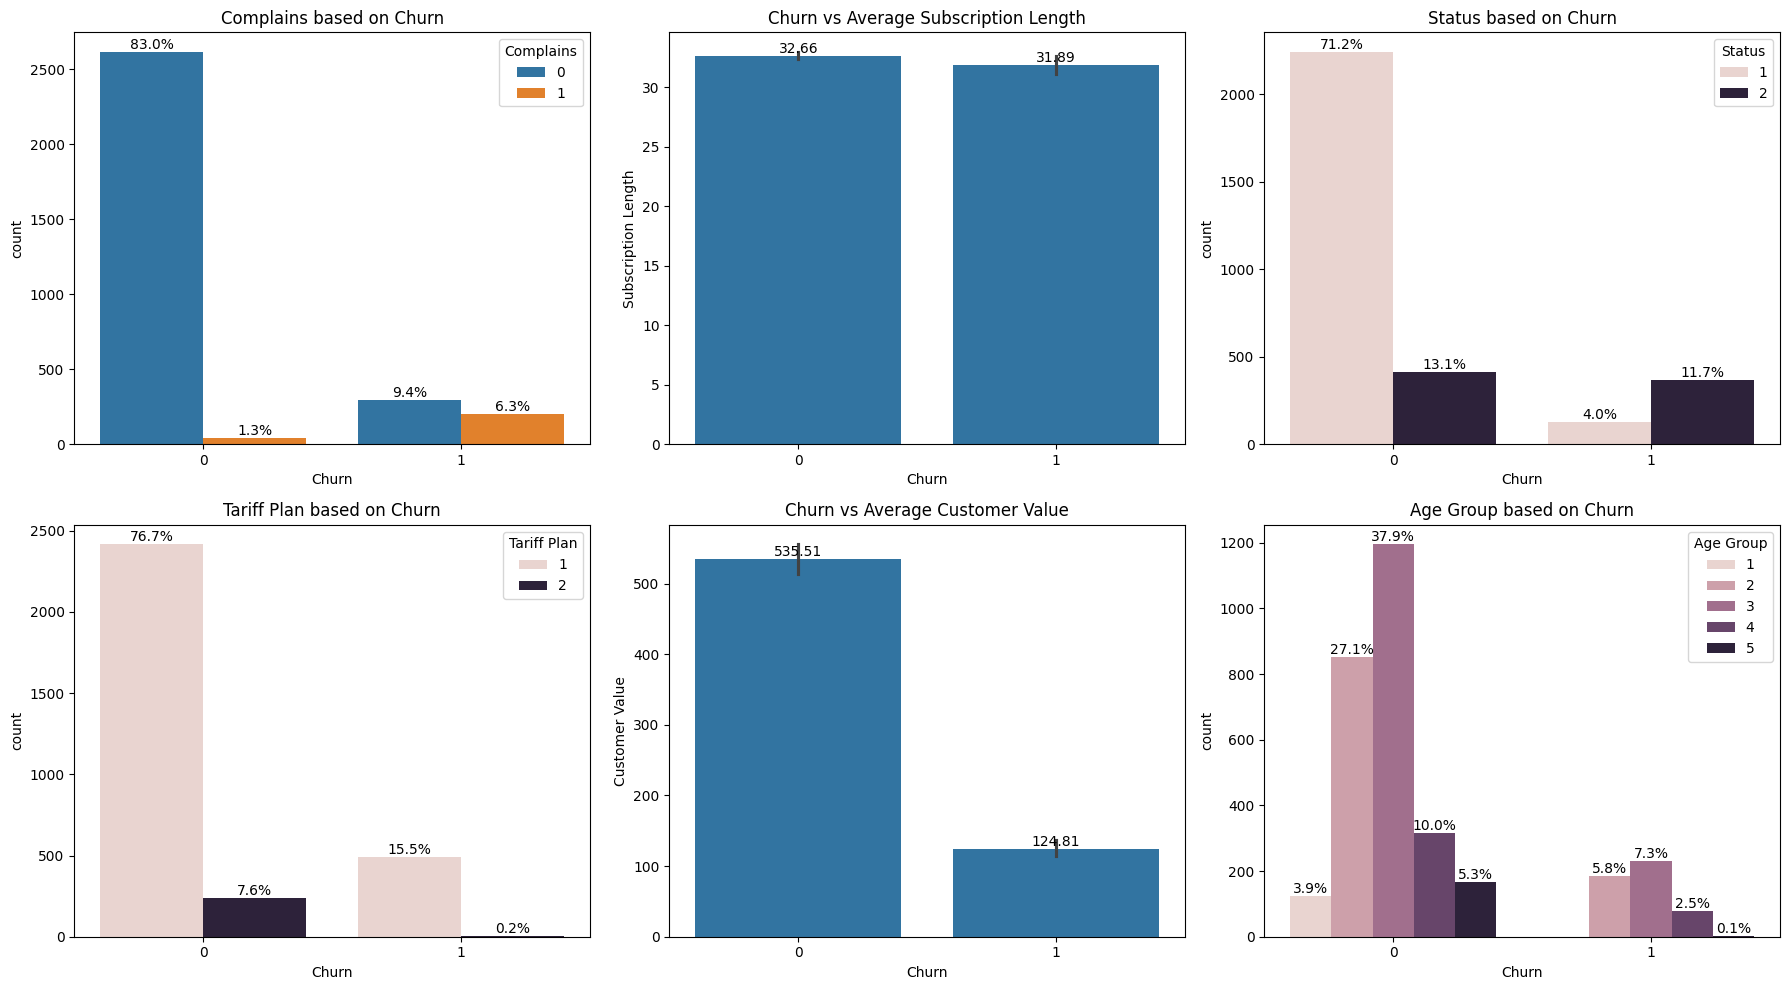

In [53]:
target_variables = ['Complains','Subscription Length','Status','Tariff Plan','Customer Value', 'Age Group']
category = 'Churn'

bi_var_analysis(category,target_variables)

#### 1. The Churn rate is 82% for Customers with Complaints but for Customers with no complaints Churn rate is only 10%.
#### 2. The Average Subscription Length of Customers who have not churned is slightly higher than that of Customers who have churned. 
#### 3. In-active Customers make up 47% of Churned Customers while Active Customers only make up 15% of Churned Customers, In-active Users churn by 47% and Active Users churn only by 5% of the total user base.
#### 4. Tariff plan 1 leads to a churn rate of 9% and Tariff Plan 2 leads to a churn rate of around 1%.
#### 5. The Average Customer Value of users who have not churned is more than 4 times that of users who have Churned.
#### 6. Churned users are mostly from Age Group 3 with 16% of users from that group having churned making up 7.3% of the total user base. However, the churn rate is highest among Age Group 4, with 20% of users from that group having churned

---

In [56]:
categorical_var.remove('Churn')

#chi-square test for categorical variables vs Churn
from scipy.stats import chi2_contingency

for col in categorical_var:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {col} vs Churn:")
    print(f"p-value: {p_value}")
    print("\n")

#T-test for numerical variables vs Churn
from scipy.stats import ttest_ind

for col in numerical_var:
    churn_group = df[df['Churn'] == 1][col]
    non_churn_group = df[df['Churn'] == 0][col]
    t_stat, p_value = ttest_ind(churn_group, non_churn_group)
    print(f"T-test for {col} vs Churn:")
    print(f"p-value: {p_value}")
    print("\n")

Chi-square test for Complains vs Churn:
p-value: 9.75604260522434e-195


Chi-square test for Charge Amount vs Churn:
p-value: 2.046805217140257e-38


Chi-square test for Age Group vs Churn:
p-value: 4.807068303259822e-12


Chi-square test for Tariff Plan vs Churn:
p-value: 4.928097701198338e-09


Chi-square test for Status vs Churn:
p-value: 6.918764667789738e-172


T-test for Call Failure vs Churn:
p-value: 0.6141034273542372


T-test for Subscription Length vs Churn:
p-value: 0.06743695364288067


T-test for Seconds of Use vs Churn:
p-value: 4.855818768548243e-66


T-test for Frequency of use vs Churn:
p-value: 4.858942301812468e-68


T-test for Frequency of SMS vs Churn:
p-value: 4.5180675921498456e-36


T-test for Distinct Called Numbers vs Churn:
p-value: 2.318825404434834e-57


T-test for Customer Value vs Churn:
p-value: 1.0207443643931265e-61




### Chi-Square Test Results

The Chi-square test evaluates the association between categorical variables and `Churn`. A significance level of $ \alpha = 0.05 $ is used to determine if the p-values indicate a significant association.

- **Complains**: $ p < 1 \times 10^{-195} $  
  _Highly significant, indicating a strong association with `Churn`._

- **Charge Amount**: $ p < 1 \times 10^{-38} $  
  _Highly significant, indicating a strong association with `Churn`._

- **Age Group**: $ p < 1 \times 10^{-12} $  
  _Highly significant, indicating a strong association with `Churn`._

- **Tariff Plan**: $ p < 1 \times 10^{-9} $  
  _Highly significant, indicating a strong association with `Churn`._

- **Status**: $ p < 1 \times 10^{-172} $  
  _Highly significant, indicating a strong association with `Churn`._

All p-values are significantly less than 0.05, suggesting a very strong relationship between each categorical variable and `Churn`.

---

### T-Test Results

The T-test compares the means of numerical variables between the two `Churn` groups. A significance level of $ \alpha = 0.05 $ is used to determine if the p-values indicate significant differences in means.

- **Call Failures**: $ p = 0.614 $  
  _Not significant, suggesting no strong evidence of an impact on `Churn`._

- **Subscription Length**: $ p = 0.067 $  
  _Marginally significant; close to the threshold, indicating a potential impact on `Churn`._

- **Seconds of Use**: $ p < 1 \times 10^{-66} $  
  _Highly significant, indicating a strong difference in means between `Churn` groups._

- **Frequency of Use**: $ p < 1 \times 10^{-68} $  
  _Highly significant, indicating a strong difference in means between `Churn` groups._

- **Frequency of SMS**: $ p < 1 \times 10^{-36} $  
  _Highly significant, indicating a strong difference in means between `Churn` groups._

- **Distinct Called Numbers**: $ p < 1 \times 10^{-57} $  
  _Highly significant, indicating a strong difference in means between `Churn` groups._

- **Customer Value**: $ p < 1 \times 10^{-61} $  
  _Highly significant, indicating a strong difference in means between `Churn` groups._

Most numerical variables show significant differences in means between the `Churn` groups, except for `Call Failures`, which does not show a significant difference.


### Chi-Square Test Results

The Chi-square test evaluates the association between categorical variables and `Churn`. A significance level of $ \alpha = 0.05 $ is used to determine if the p-values indicate a significant association.

- **Complains**: $ p < 1 \times 10^{-195} $  
  _`Highly significant`, indicating a strong association with Churn._

- **Charge Amount**: $ p < 1 \times 10^{-38} $  
  _`Highly significant`, indicating a strong association with Churn._

- **Age Group**: $ p < 1 \times 10^{-12} $  
  _`Highly significant`, indicating a strong association with Churn._

- **Tariff Plan**: $ p < 1 \times 10^{-9} $  
  _`Highly significant`, indicating a strong association with Churn._

- **Status**: $ p < 1 \times 10^{-172} $  
  _`Highly significant`, indicating a strong association with Churn._

All p-values are significantly less than 0.05, suggesting a very strong relationship between each categorical variable and `Churn`.

---

### T-Test Results

The T-test compares the means of numerical variables between the two `Churn` groups. A significance level of $ \alpha = 0.05 $ is used to determine if the p-values indicate significant differences in means.

- **Call Failures**: $ p = 0.614 $  
  _`Not significant`, suggesting no strong evidence of an impact on Churn._

- **Subscription Length**: $ p = 0.067 $  
  _`Marginally significant`; close to the threshold, indicating a potential impact on Churn._

- **Seconds of Use**: $ p < 1 \times 10^{-66} $  
  _`Highly significant`, indicating a strong difference in means between Churn groups._

- **Frequency of Use**: $ p < 1 \times 10^{-68} $  
  _`Highly significant`, indicating a strong difference in means between Churn groups._

- **Frequency of SMS**: $ p < 1 \times 10^{-36} $  
  _ `Highly significant`, indicating a strong difference in means between Churn groups._

- **Distinct Called Numbers**: $ p < 1 \times 10^{-57} $  
  _`Highly significant`, indicating a strong difference in means between Churn groups._

- **Customer Value**: $ p < 1 \times 10^{-61} $  
  _`Highly significant`, indicating a strong difference in means between Churn groups._

Most numerical variables show significant differences in means between the `Churn` groups, except for `Call Failures`, which does not show a significant difference.


## Models Robust to Multicollinearity

1. **Ridge Regression (L2 regularization)**
2. **Lasso Regression (L1 regularization)**
3. **Elastic Net (combination of L1 and L2)**
4. **Decision Trees and Random Forests**
5. **Gradient Boosting Machines**

# Correlation Analysis

In [61]:
# Perform VIF analysis
X = add_constant(df.drop('Churn', axis=1))

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature        VIF
0                     const  75.917072
1              Call Failure   2.912543
2                 Complains   1.153754
3       Subscription Length   1.181161
4             Charge Amount   3.187304
5            Seconds of Use  22.259828
6          Frequency of use  18.813718
7          Frequency of SMS  41.675949
8   Distinct Called Numbers   2.403947
9                 Age Group   2.099784
10              Tariff Plan   1.559899
11                   Status   1.850061
12           Customer Value  52.692463


**Interpreting the VIF Results**

VIF > 10: This generally indicates high multicollinearity that could be problematic.

VIF between 5 and 10: This suggests moderate multicollinearity that might need addressing depending on the context.

VIF < 5: Low multicollinearity, usually not a concern.


### Variance Inflation Factor (VIF) Results

The Variance Inflation Factor (VIF) measures how much the variance of an estimated regression coefficient increases if your predictors are correlated. A VIF value greater than 10 suggests a problematic amount of multicollinearity.

| Feature                  | VIF       |
|--------------------------|-----------|
| Call Failure             | 2.91      |
| Complains                | 1.15      |
| Subscription Length      | 1.18      |
| Charge Amount            | 3.19      |
| Seconds of Use           | 22.26     |
| Frequency of use         | 18.81     |
| Frequency of SMS         | 41.68     |
| Distinct Called Numbers  | 2.40      |
| Age Group                | 2.10      |
| Tariff Plan              | 1.56      |
| Status                   | 1.85      |
| Customer Value           | 52.69     |

**Key Insights:**
- **High VIF Values**: `Seconds of Use`, `Frequency of use`, `Frequency of SMS`, and `Customer Value` have very high VIF values, indicating substantial multicollinearity.
- **Low VIF Values**: Features with VIF values below 5, including `Call Failure`, `Complains`, `Subscription Length`, `Charge Amount`, `Distinct Called Numbers`, `Age Group`, `Tariff Plan`, and `Status`, have relatively low multicollinearity, which is less likely to distort the regression coefficients.
   
High VIF values could indicate redundancy among features and may suggest the need for feature selection or transformation.


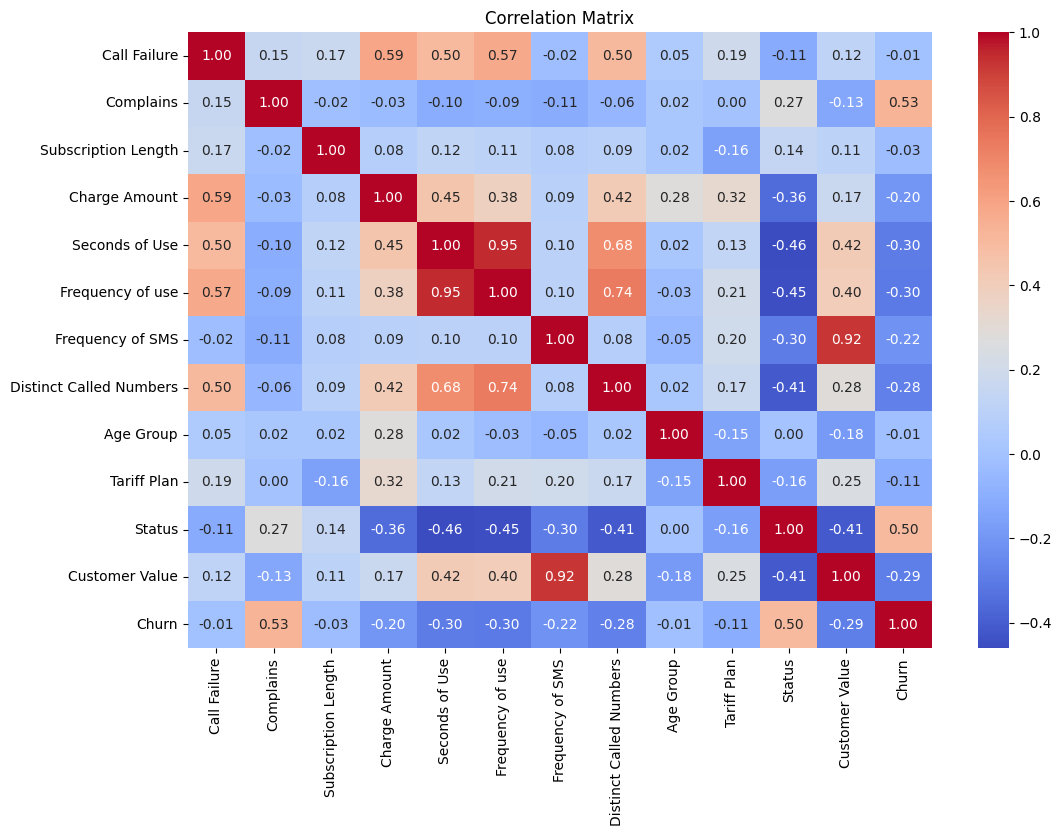

In [64]:
# Plotting correlation heatmap
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# Model Training

In [66]:
# Seperating target and features
X = df.drop('Churn', axis=1)
y = df['Churn']

df['Total_Usage'] = df['Frequency of use'] + df['Seconds of Use'] + df['Frequency of SMS']

df.drop(['Frequency of use', 'Seconds of Use', 'Frequency of SMS'], axis=1, inplace=True)


Training the model on one of the best performing ensemble methods currently existing, XGBoost.

In [69]:
# Finding class imbalance
neg_class = (y == 0).sum()
pos_class = (y == 1).sum()

class_ratio = neg_class / pos_class
print(f"Ratio of Classes (Negative/Positive): {class_ratio}")

Ratio of Classes (Negative/Positive): 5.363636363636363


In [73]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
# Defining Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42, scale_pos_weight=class_ratio))
])

The pipeline will handle preprocessing (scaling) and model training (XGBoost), scaling is applied only on the training data within each fold of cross-validation.
This avoids any data leakage, which could otherwise occur if preprocessing is applied globally before splitting the data.

In [78]:
# Hyperparameters to be tunes with GridSearchCV or RandomSearchCV
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.3],
    'xgb__reg_lambda': [1, 1.5],
    'xgb__reg_alpha': [0, 0.1]
}

In [80]:
# Performing Grid Search Cross Validation
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=2,
    n_jobs=-1,
    refit='f1',
    return_train_score=True
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_ty...
             param_grid={'xgb__colsample_bytree': [0.8, 1.0],
                         'xgb__gamma': [0, 0.1, 0.3],
                         'xgb__learning_rate': [0.01, 0.1, 0.3],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__min_child_weight': [1, 3, 5],
                         'xgb__n_estimators': [100, 200, 300],
                         'xgb__reg_alpha': [0, 0.1],
                         'xgb__reg_lambda': [1, 1.5],
                         'xgb__subsample': [0.8, 1.0]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

In [105]:
# Storing the parameters, model and results of the Best performing model in GridSearchCV
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")
best_model = grid_search.best_estimator_
cv_results = grid_search.cv_results_

# Calculate and print metrics
for metric in scoring:
    mean_score = np.mean(cv_results['mean_test_' + metric])
    std_score = np.std(cv_results['mean_test_' + metric])
    print(f"{metric.capitalize()} - Mean: {mean_score:.4f}, Std: {std_score:.4f}")

Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 300, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 1.5, 'xgb__subsample': 0.8}
Accuracy - Mean: 0.9383, Std: 0.0280
Precision - Mean: 0.7603, Std: 0.1002
Recall - Mean: 0.9103, Std: 0.0121
F1 - Mean: 0.8240, Std: 0.0625
Roc_auc - Mean: 0.9785, Std: 0.0104


In [107]:
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision
precision = precision_score(y_test, y_pred)
# Recall
recall = recall_score(y_test, y_pred)
# F1 Score
f1 = f1_score(y_test, y_pred)
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

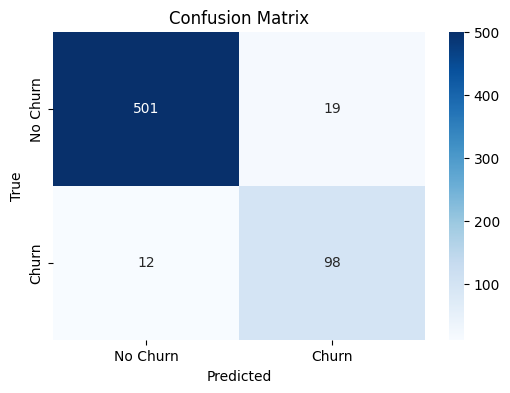

Accuracy: 0.9508
Precision: 0.8376
Recall: 0.8909
F1 Score: 0.8634
ROC-AUC Score: 0.9801

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       520
           1       0.84      0.89      0.86       110

    accuracy                           0.95       630
   macro avg       0.91      0.93      0.92       630
weighted avg       0.95      0.95      0.95       630



In [109]:
# Display confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

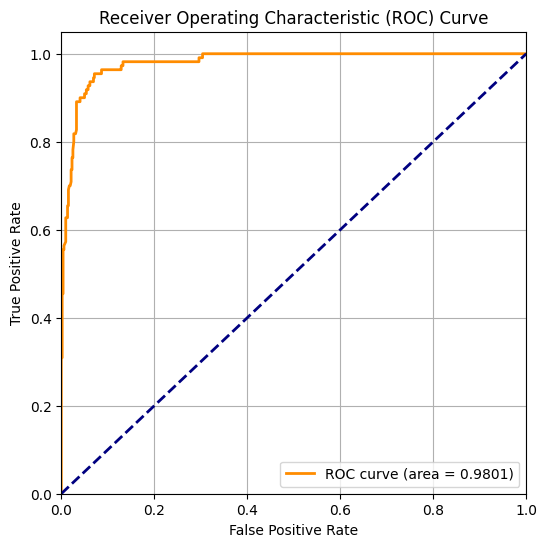

In [111]:
# Plotting 
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

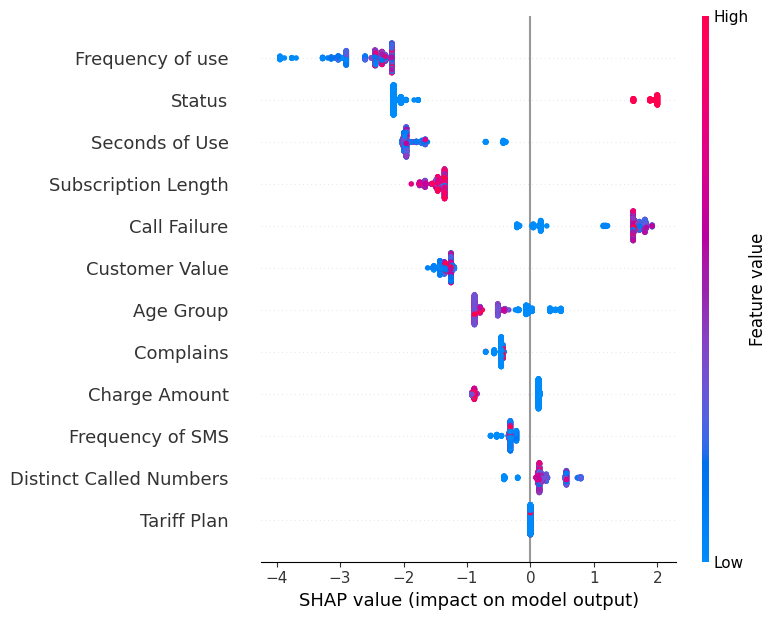

In [117]:
# SHAP analysis of Ensemble method
shap.initjs()

model = best_model.named_steps['xgb']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [119]:
# Save model as pickle file
pipeline.fit(X_train, y_train)
dump(pipeline, 'xgboost_pipeline.pkl')


['xgboost_pipeline.pkl']